# 1. Set enviroment

In [1]:
# Select an interactive backend for plotting
# check all the options by: %matplotlib -l
%matplotlib -l

# I prefer to choose qt5 which will pop up a new window for each plot. 
# Here, for inline presentation, I choose nbagg.
%matplotlib nbagg
# %matplotlib qt5 

# Reload all modules everytime before executing the Python code typed. 
# Sometimes it didnot work. I will reload the script manually by 'reload(pe)'
%load_ext autoreload
%autoreload 2

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [2]:
import matplotlib.pylab as plt
import numpy as np
import os, glob, sys
from copy import deepcopy
sys.path.append('/Users/your_user_name/your_folder_for_scripts')
import process_EELS as pe
from importlib import reload
import json

# download lmfit for curve fitting
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ExponentialModel, PowerLawModel
from lmfit import Parameters

# 2. Load data

In [3]:
# Set the folder where your data is.
folder = '/Users/your_user_name/your_folder_for_data'

# Get all the file names in the folder with a npy format. (I will save SI data in the numpy files.)
# You can change the loading function based on the file format only if the final outputs are numpy arrays.
os.chdir(folder)
file_names = sorted(glob.glob('*.npy')) #'sorted' sorts into alphabetical order
file_names = file_names[:]
for i, f in enumerate(file_names):
    print('{}: {}'.format(i,f))

# Load data into data_list and metadata into metadata_list.
# We will need the metadata files to recontruct the x-axis of the spectra.
# Here, for nionswift, we have .json files as metadata files.
data_list = []
x_list = []
for file in file_names:
    data_list.append(np.load(folder+file))
    with open(folder + file[:-4] +'.json') as json_data:
        metadata = json.load(json_data)
        scale = metadata['spatial_calibrations'][2]['scale']
        offset = metadata['spatial_calibrations'][2]['offset']
        x_list.append(np.linspace(0, data_list[0].shape[2]-1, data_list[0].shape[2]) * scale + offset)

# For EELS mapping data, each element of data_list is an (m, n, k) array, 
# where (m, n) is the spatial dimension, k is the channel number of EELS.
new_data_list = []
for i in range(len(data_list)):
    new_data_list.append([x_list[i], data_list[i]])


0: 1.npy


# 3. Process Data
We will present the following examples based on Map (Lines) class:

1: Initial process (align, and normalize).  
2: Slice display.  
3: Decomposition by PCA (or NMF).  
4: Summming over all the pixels.  

### Example 1: Initial process (align, and normalize)

<IPython.core.display.Javascript object>


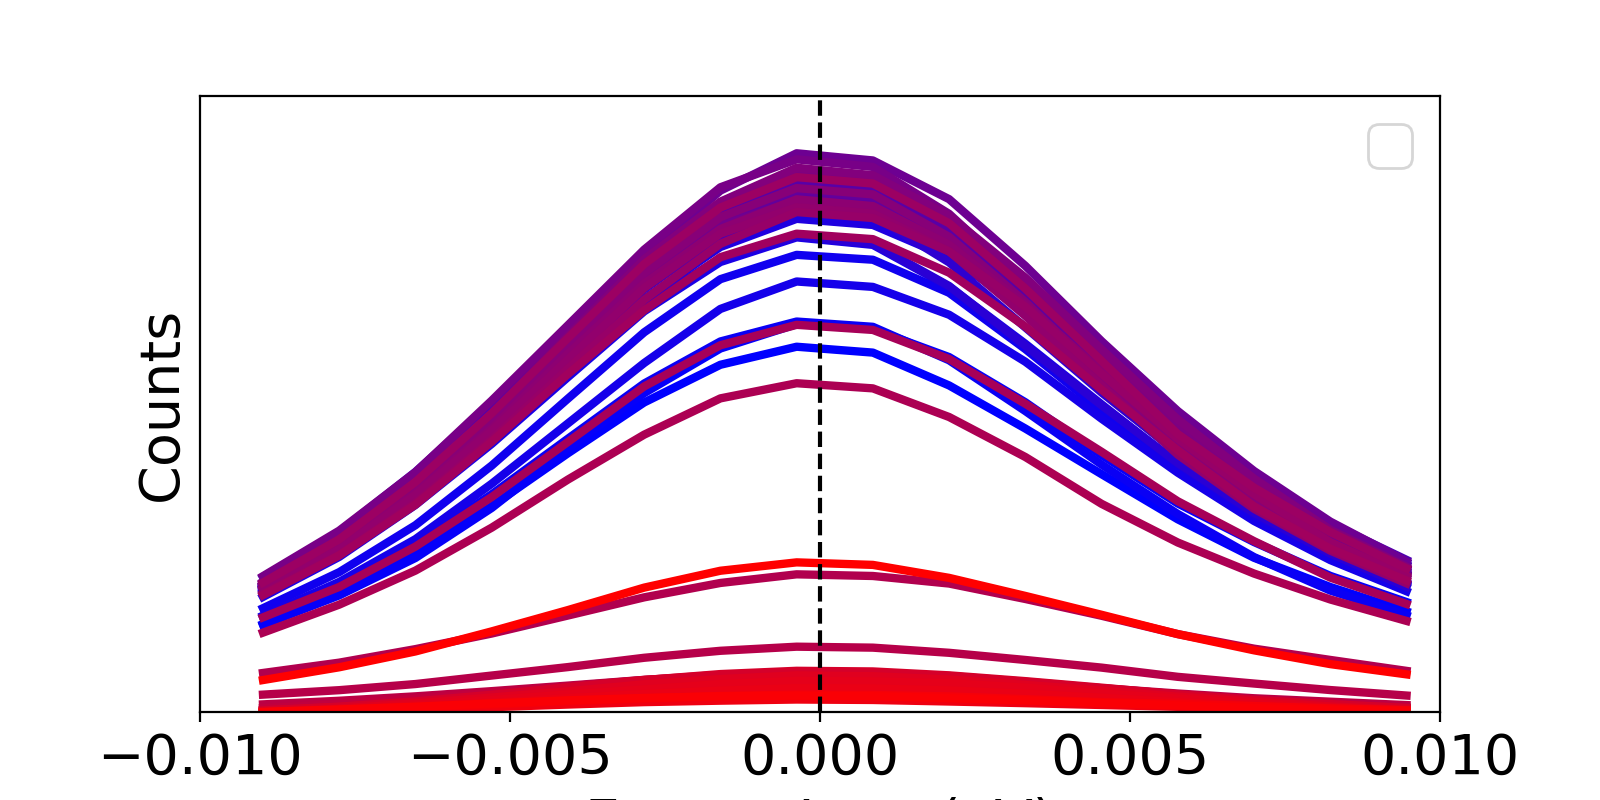

No handles with labels found to put in legend.


Job 0 is finished in 17.2378249168396 s


In [4]:
# Example 1: align, and normalize. 
# Check the alignment result by selecting 50 sample lines.
import time
reload(pe)
map_list = []
for i, e in enumerate(new_data_list):
    t1 = time.time()
    
    # Initial process
    map1 = pe.Mapping()
    # we can initial data by the following, xdata (an (k,) array) and ydata (an (m, n, k) array).
    # or by self.set_initial_elements in Lines class, each element is a Line, 
    # Line.data[0] is x-values and Line.data[1] is y-values.
    # No matter which way, the class will store the data in self.elements format. 
    # We can always recontruct 2D data (m*n, k) into 3D data (m, n, k)
    map1.set_initial_by_data(xdata=e[0], ydata=e[1])
    map1.align()
    map1.normalize_map()
    
    # Choose 50 sample lines.
    num_points = 50
    sel_list = [int(i) for i in np.linspace(0, len(map1.elements)-1, num_points)]
    map1.elements = [map1.elements[i] for i in sel_list]
    # Figure setting
    xrange = [-0.01, 0.01]
    color_step = (np.array([1,0,0]) - np.array([0,0,1])) / (len(map1.elements) - 1)
    color_list = [np.array([0,0,1]) + color_step * i for i in range(len(map1.elements))] # Color of each element in figure
    config = {'figure_size' : [8,4],
              'xrange' : xrange,
              'color_list' : color_list}
    map1.make_plot(config)
    ax = plt.gca()
    plt.plot([0,0],ax.get_ylim(),'k--',label='x = 0')
    
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

#### Tips:
Actually we can split every example into two parts:  
initial processing (initial, align, normalize), and further processing.

After initial processing, we can save our results in map_list which will save a lot of time.  
Here, for a completeness of each example, we will do initial process every time.

In [5]:
# # Save the list of Map objects.
# import pickle
# file_map = folder+'map_list.eels'
# with open(file_map, 'wb') as f:
#     pickle.dump(map_list,f)

In [6]:
# # Load the list of Map objects.
# import pickle
# file_map = folder+'map_list.eels'
# with open(file_map, 'rb') as f:
#     map_list = pickle.load(f)

### Example 2: Slice display.

<IPython.core.display.Javascript object>


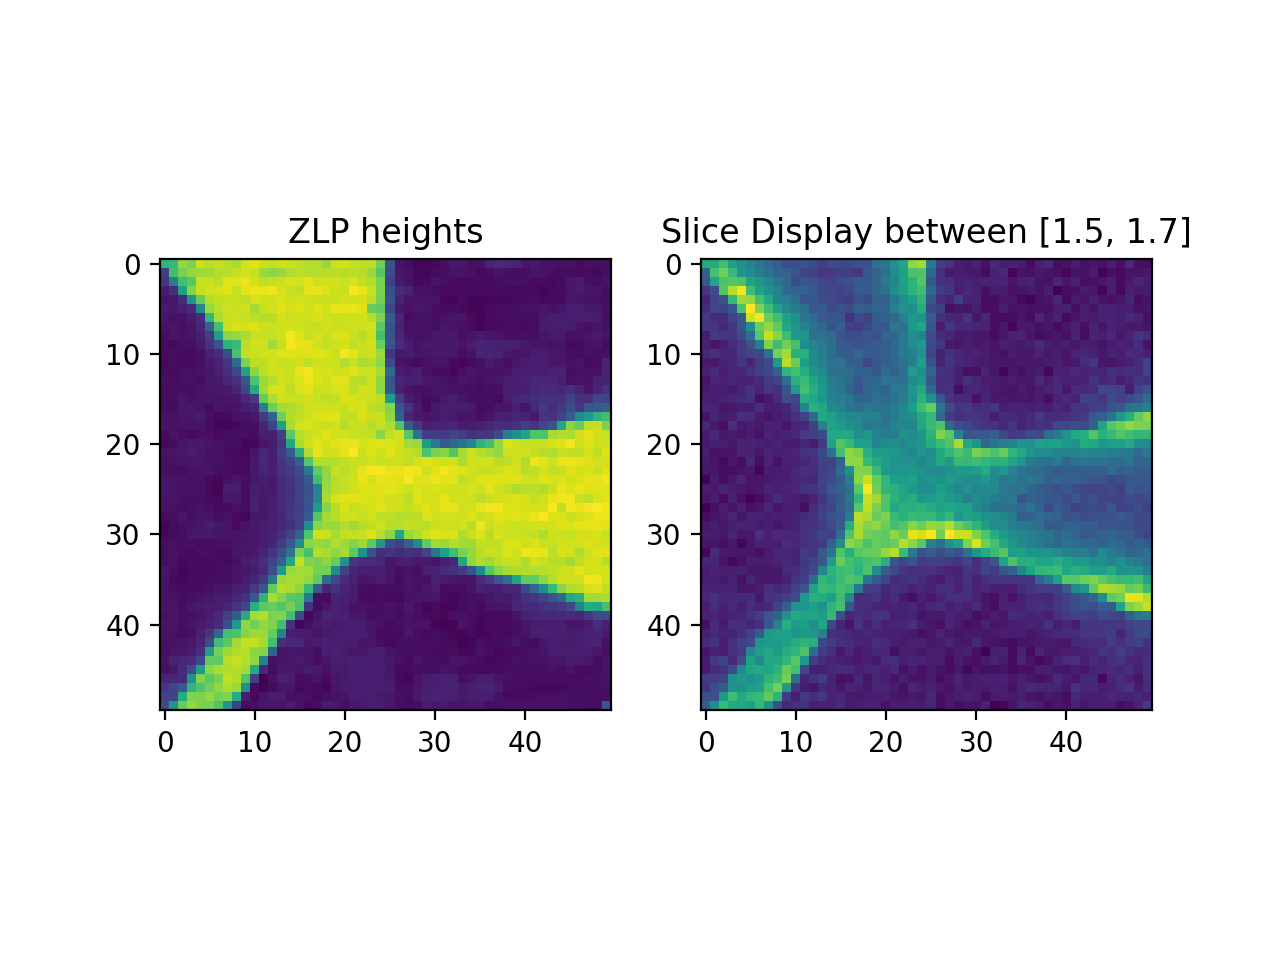

/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Job 0 is finished in 53.588324785232544 s


In [7]:
# Example 2: align, normalize and slice display. 
# Plot ZLP heights to present the sample, and then plot slice display.
import time
reload(pe)
map_list = []
for i, e in enumerate(new_data_list):
    t1 = time.time()

    map1 = pe.Mapping()
    map1.set_initial_by_data(xdata=e[0], ydata=e[1])
    map1.align()
    map1.normalize_map()
    
    # plot ZLP height to see thickness change
    plt.subplots(12)
    plt.subplot(121)
    a=map1.heights
    b=np.reshape(a,[map1.pixel_num_x,map1.pixel_num_y])
    plt.imshow(b)
    plt.title('ZLP heights')
    
    plt.subplot(122)
    xrange = [1.5, 1.7]
    a=map1.slice_display(xrange)
    b=np.reshape(a,[map1.pixel_num_x,map1.pixel_num_y])
    plt.imshow(b)
    plt.title('Slice Display between {}'.format(xrange))
    
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

### Example 3: Decomposition by PCA (or NMF).

<IPython.core.display.Javascript object>


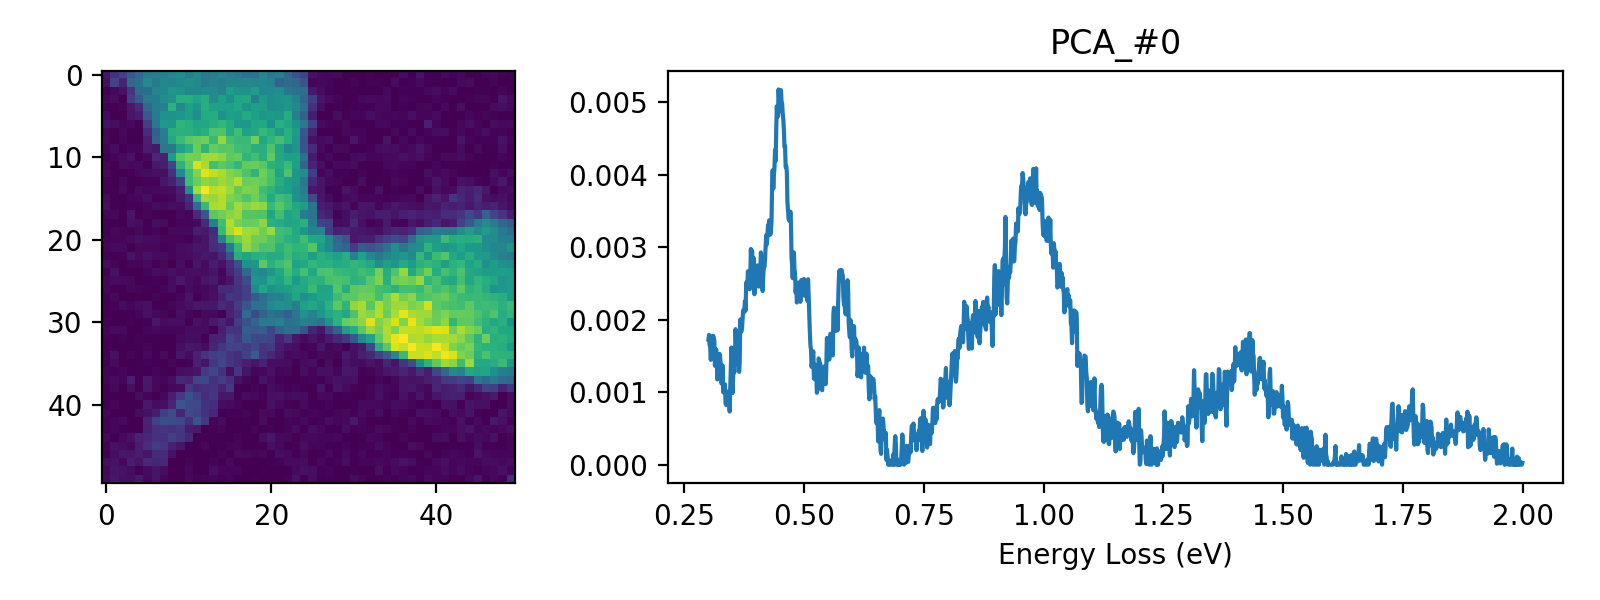

<IPython.core.display.Javascript object>


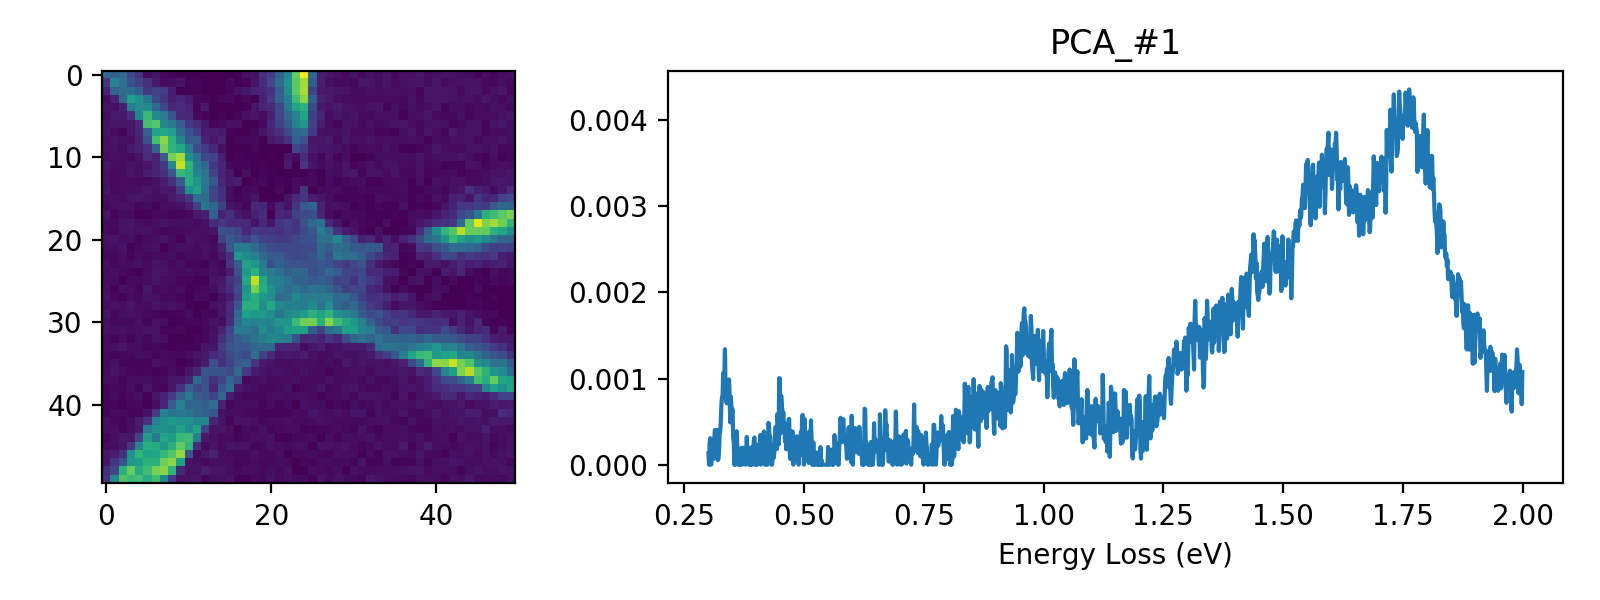

<IPython.core.display.Javascript object>


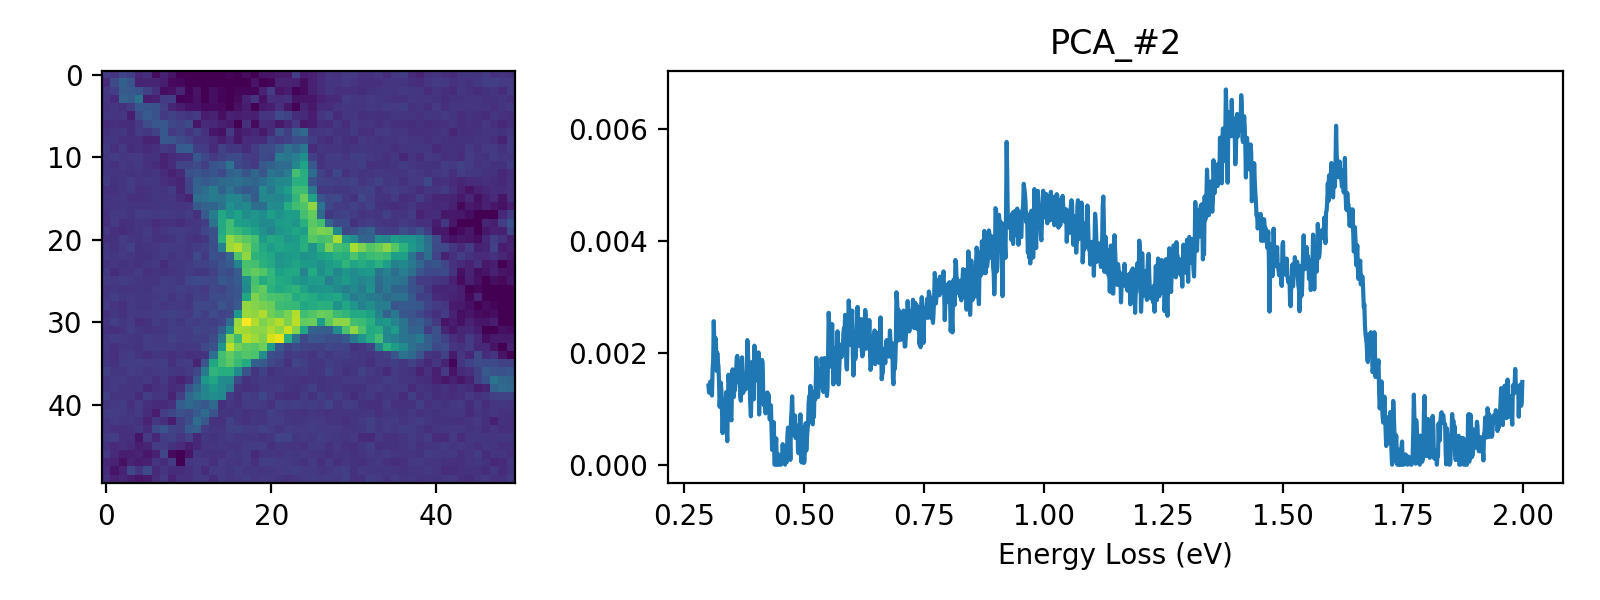

<IPython.core.display.Javascript object>


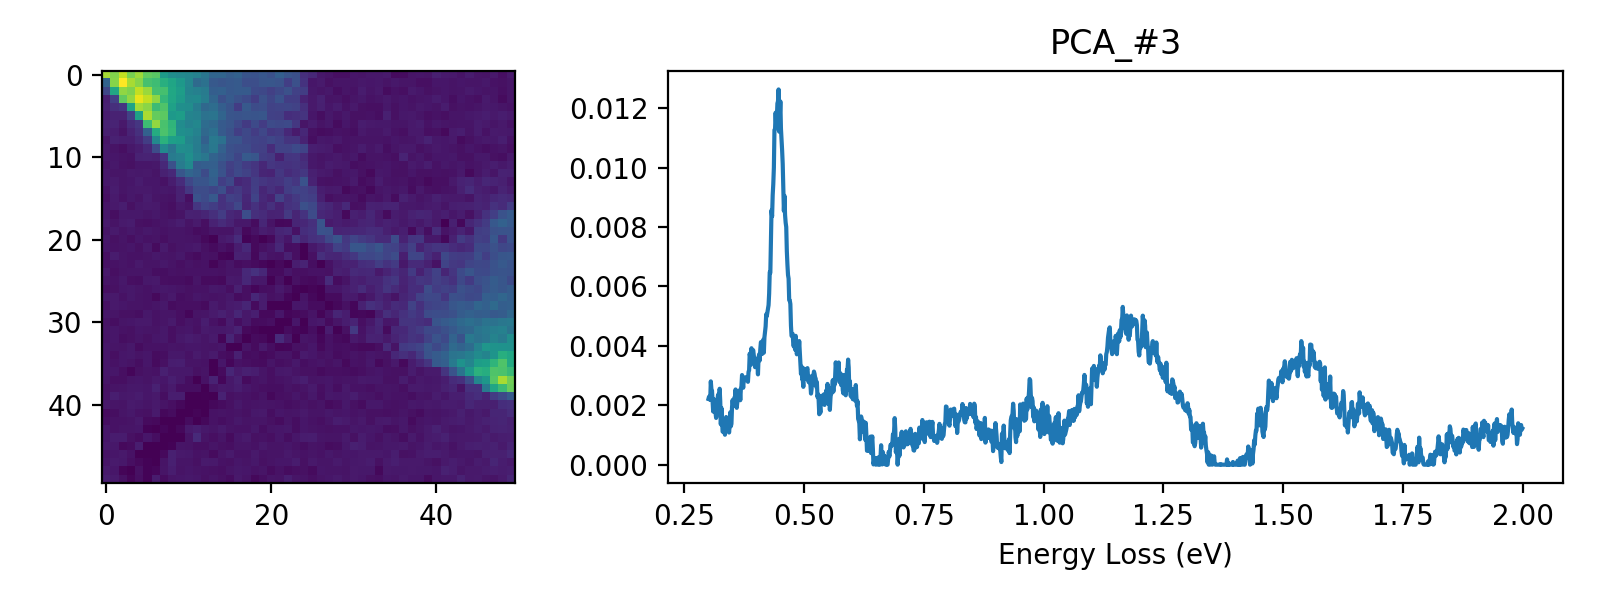

<IPython.core.display.Javascript object>


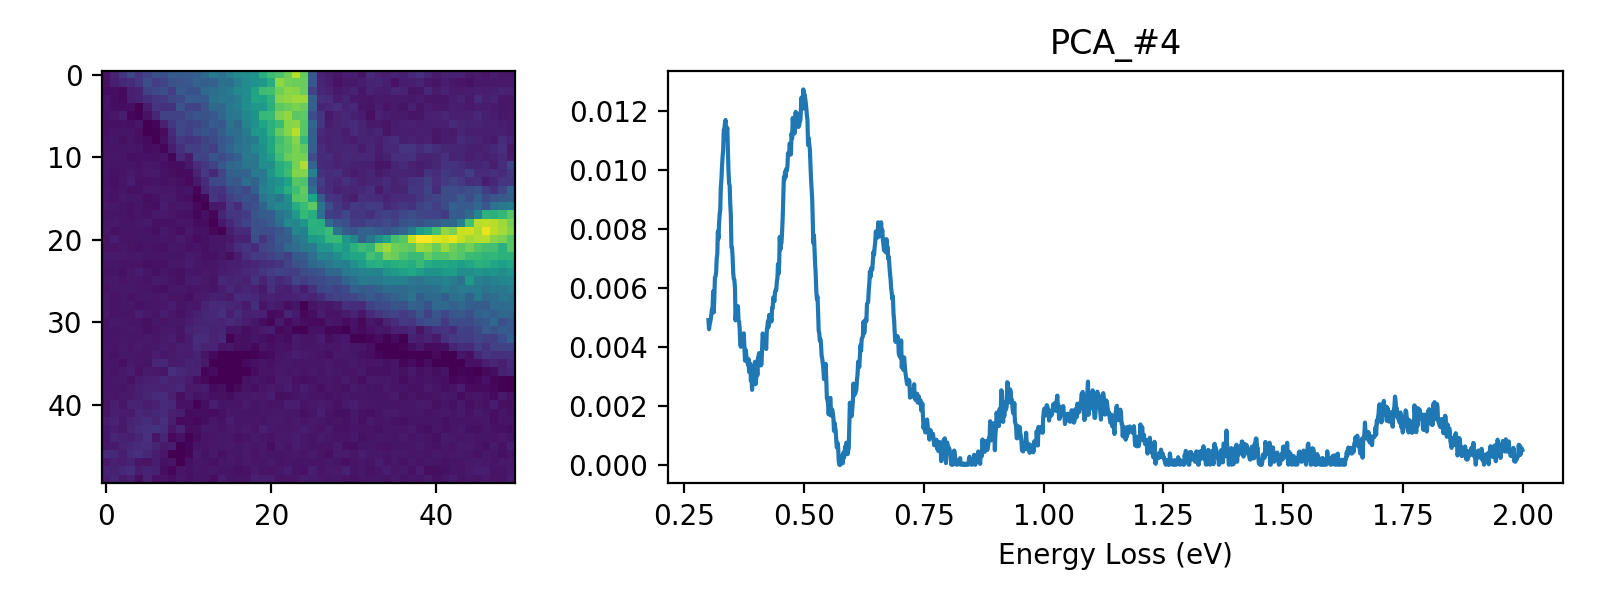

<IPython.core.display.Javascript object>


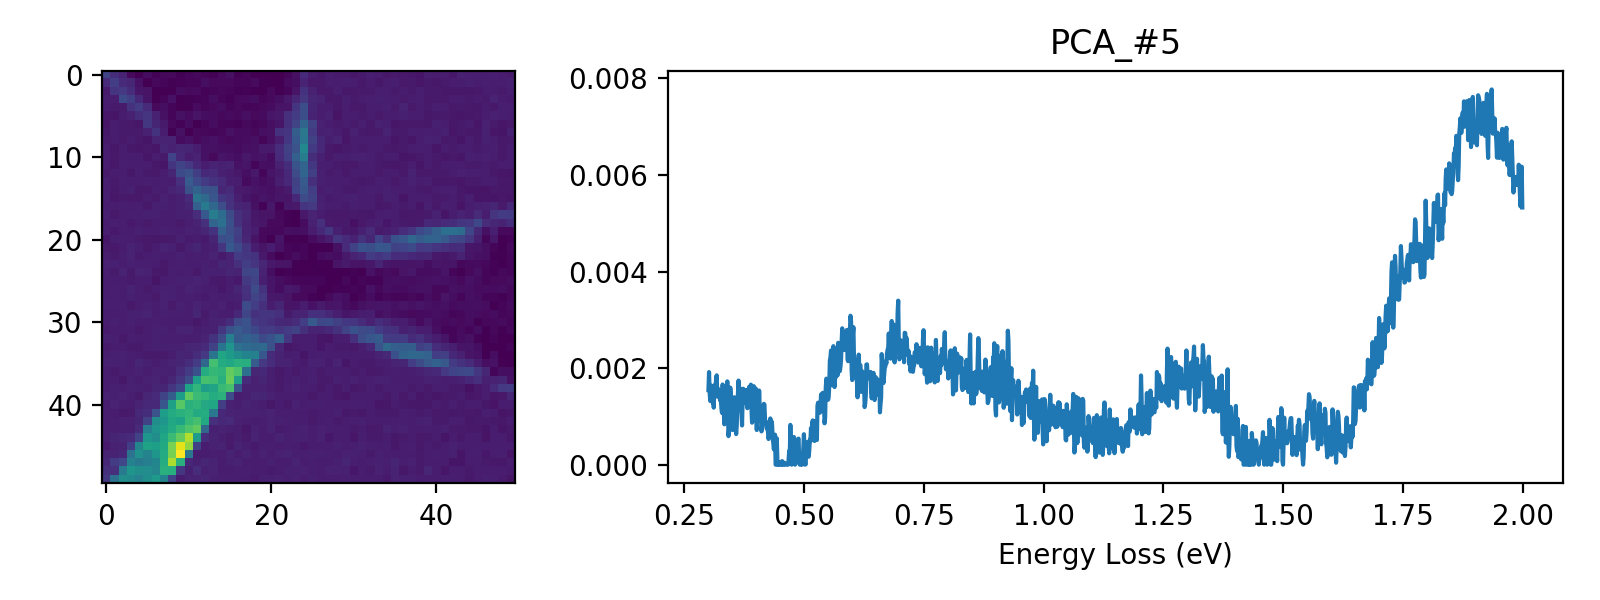

Job 0 is finished in 26.06682801246643 s


In [8]:
# Example 3: align, normalize and decomposite by PCA (or NMF).
# For each map, it will generate 6 principal components.
# You can specify the path to save the images by 'map1.PCA_plot(file_prefix='')'
# file_prefix can by any srting or even folder name
# Then the figures will be automatically saved to, file_prefix + 'PCA_#{}.png'. You can change it in the raw code.

# Tips: Slice data to exclude ZLP before PCA.
import time
reload(pe)
map_list = []
for i, e in enumerate(new_data_list):
    t1 = time.time()

    map1 = pe.Mapping()
    map1.set_initial_by_data(xdata=e[0], ydata=e[1])
    map1.align()
    map1.normalize_map()
    xrange = [0.3, 2]
    map1.slice_data(xrange)
    map1.PCA(6)
    map1.PCA_plot()
    map_list.append(map1)
    
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

### Example 4: Summing over all the pixels.

<IPython.core.display.Javascript object>


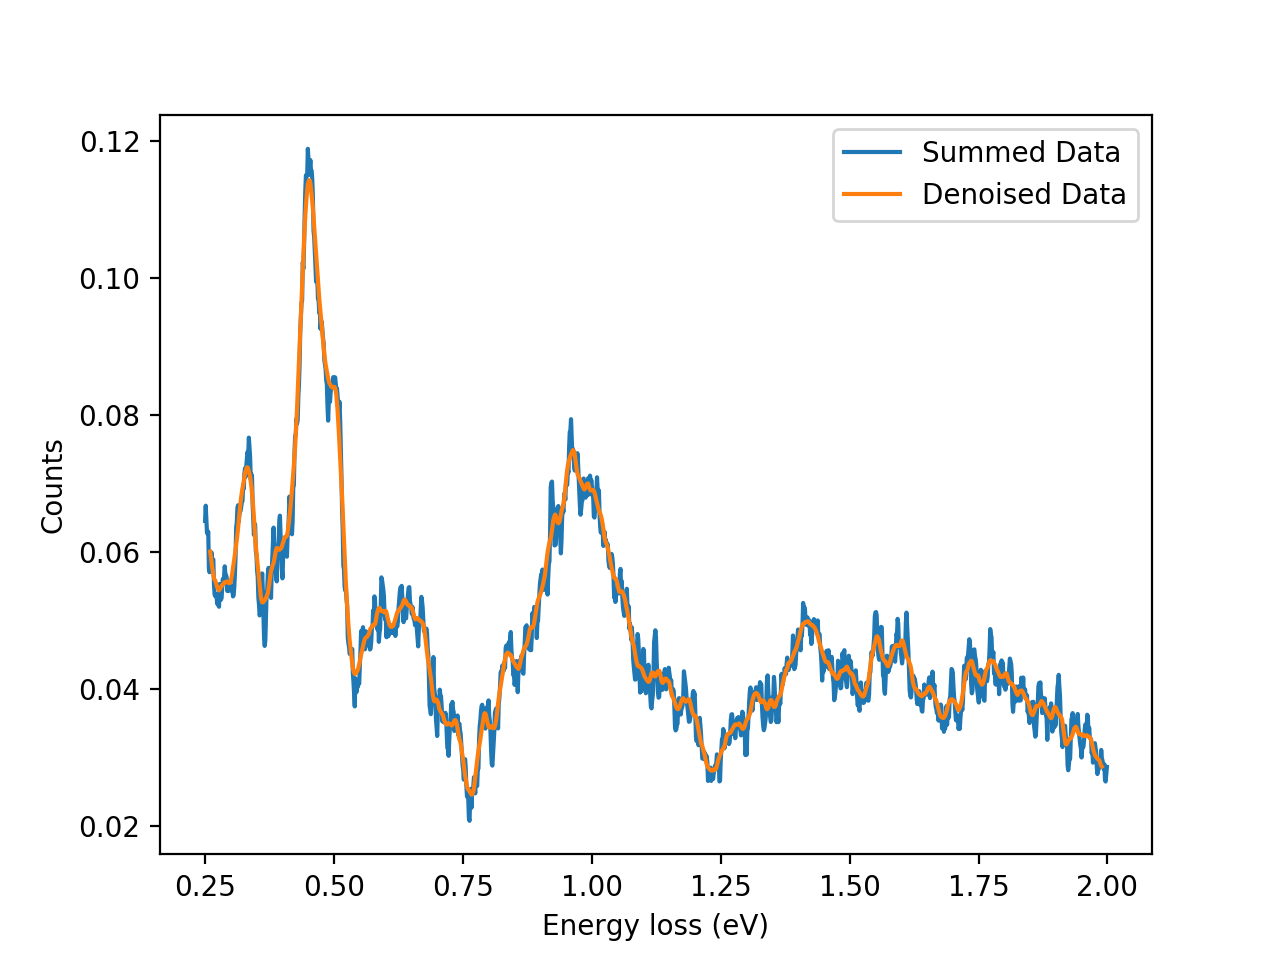

Job 0 is finished in 20.003894805908203 s


In [9]:
# Example 4: align, normalize, and sum the data from all the pixels to one spectrum with denoising.

import time
reload(pe)
spectra_list = []
for i, e in enumerate(new_data_list):
    t1 = time.time()
    
    map1 = pe.Mapping()
    map1.set_initial_by_data(xdata=e[0], ydata=e[1])
    map1.align()
    map1.normalize_map()
    
    line1 = pe.Line(map1.select_sum_all(), 'Summed Data')
    xrange = [0.25, 2]
    line1.data = line1.slice_data(xrange)
    plt.figure()
    line1.plot()
    line1.data = line1.denoise_LLR()
    line1.name = 'Denoised Data'
    line1.plot()
    plt.legend()
    spectra_list.append(line1)
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

# 4. Additional functions

### Sum by Selection 1:
The spectra can be summed by specify a selected list of element numbers.

Here, specifically, I design two function to choose the center areas.

1, classify_by_heights: this will divide the images into two regions (samples, substrates), based on the ZLP heights.

2, find_center: this will find the center and radius to sum with a good initial guess.



In [10]:
def classify_by_heights(map1):
    """
    divide mapping into two regions (samples, substrates), based on the ZLP heights.
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import normalize
    heights = np.array(map1.heights)
    thickmat = np.reshape(heights, [map1.pixel_num_x, map1.pixel_num_y])
    #divide the data into clusters based on kmeans the thickness
    sp = np.shape(thickmat)
    task = []
    for i in range(sp[0]):
        for j in range(sp[1]):
            task.append([i,j,thickmat[i,j]])
    t=np.array(task)

    t[np.isnan(t)]=0
    #t2=normalize(t,axis=0)
    t3=deepcopy(t)
    #t3[:,2]=t3[:,2]*4

    #num_clusters = get_k_number(task)
    num_clusters = 2
    estimator = KMeans(n_clusters=num_clusters)
    estimator.fit(t3)
    label_pred = estimator.labels_
    centroids = estimator.cluster_centers_ 
    #print('KMeans error: ',estimator.inertia_)
    lb = np.reshape(label_pred,np.shape(thickmat))
    label_points = []
    for i in range(sp[0]):
        for j in range(sp[1]):
            if lb[i,j] == np.argmax(centroids[:,2]):
                label_points.append([i, j])
    
    return centroids, lb, label_points


def find_center(centroids, lb, center):
    newlb = 0*lb
    p1, p2 = lb.shape
    t4 = []
    for i in range(p1):
        for j in range(p2):
            if lb[i,j] == np.argmax(centroids[:,2]):
                newlb[i,j] = 1
            t4.append([i,j,newlb[i,j]])
    # center = centroids[np.argmax(centroids[:,2]),:2]
    # center = [10,10]
    num_points = []
    tol = 0.05
    step = 1
    while True:
        radius = lb.shape[0] / 2
        is_stop = False
        while True:
            if radius < 1:
                is_stop = True
                print('Radius is 0. The center is far away from real center.')
                break
            new_list = []
            for i in t4:
                if (i[0] - center[0]) ** 2 + (i[1] - center[1]) ** 2 <= radius ** 2:
                    new_list.append(i)
            label_points = [[e[0], e[1]] for e in new_list if e[2] == 1] 
            label_ratio = np.sum(new_list, axis=0)[2] / len(new_list) 
            # print(len(label_points), label_ratio)
            if label_ratio > 1 - tol:
                num_points.append(len(label_points))
                break
            radius = radius - step
            
        center = np.sum(label_points, axis=0) / len(label_points)
        if len(num_points) >= 2:
            if abs(num_points[-1]/num_points[-2]-1) < tol/10:
                print('Optimal circle: center ({}), radius ({})'.format(center, radius))
                new_list = []
                for i in t4:
                    if (i[0] - center[0]) ** 2 + (i[1] - center[1]) ** 2 <= (0.6 * radius) ** 2:
                        new_list.append(i)
                label_points = [[e[0], e[1]] for e in new_list if e[2] == 1] 
                break
        if is_stop:
            break
        
    return center, radius, label_points

### Sum by Selection 2:
The initial guess of center can be found by the representative point of the geometry. 

Then the spectra summed only from the center of one region are obtained in spectra_list

Optimal circle: center ([21.29787234 24.70212766]), radius (4.0)


<IPython.core.display.Javascript object>


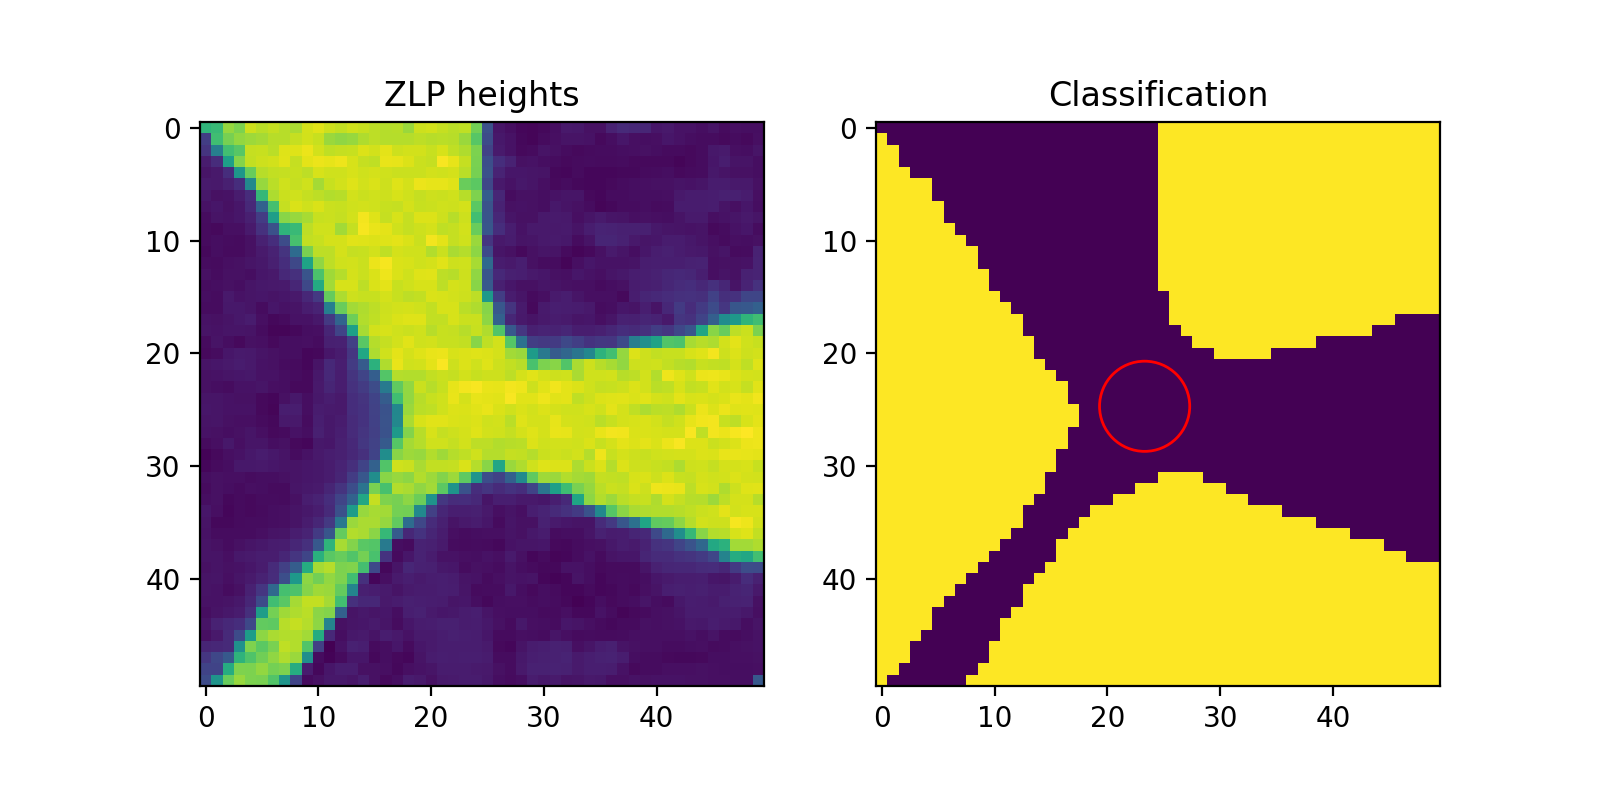

<IPython.core.display.Javascript object>


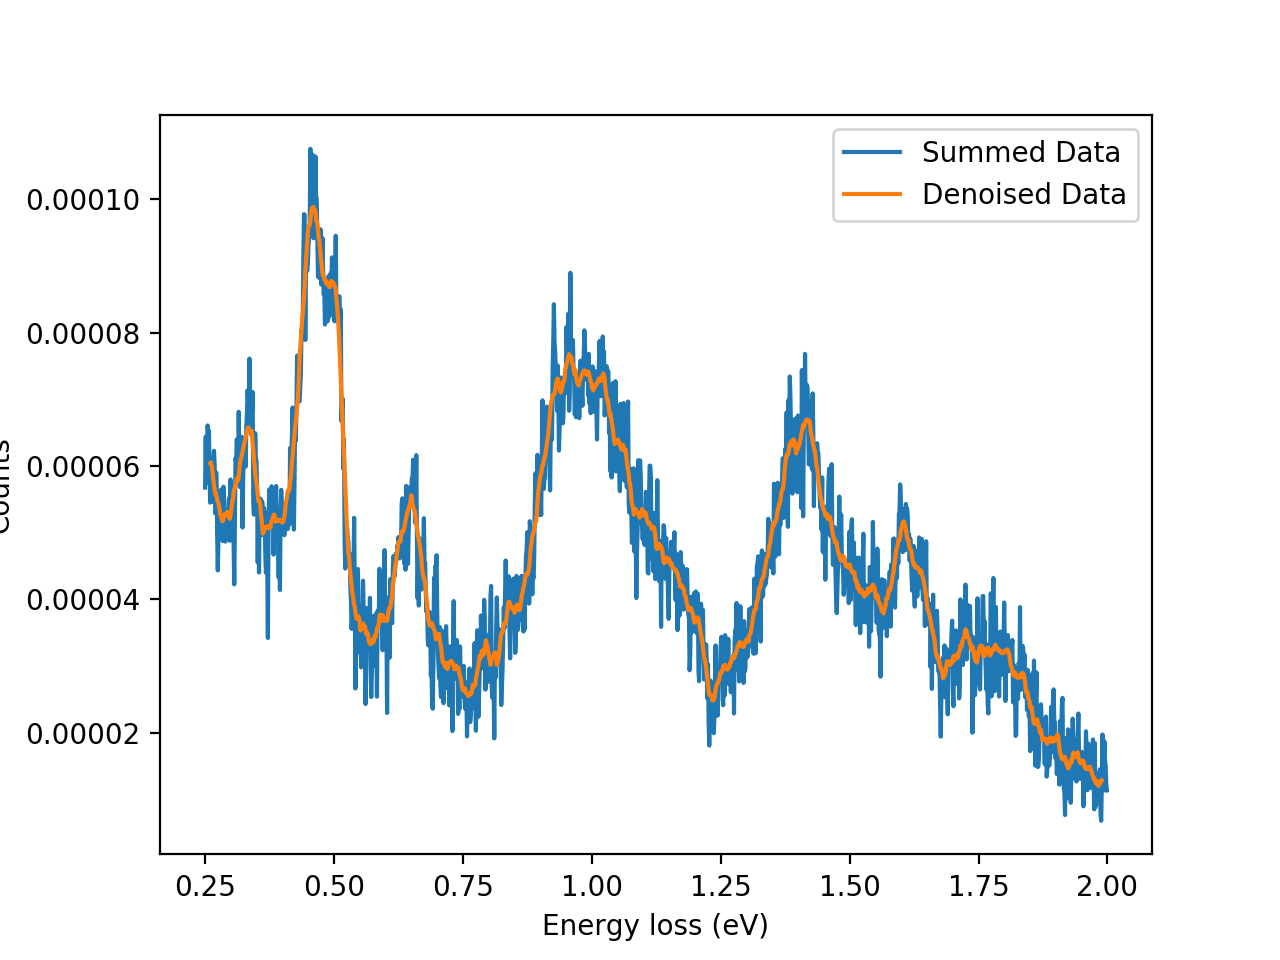

Job 0 is finished in 20.483070850372314 s


In [11]:
from shapely.geometry import MultiPoint
import time
spectra_list = []
for i, e in enumerate(new_data_list):
    t1 = time.time()
    
    map1 = pe.Mapping()
    map1.set_initial_by_data(xdata=e[0], ydata=e[1])
    map1.align()
    map1.normalize_map()
    
    centroids, lb, label_points = classify_by_heights(map1)
    points = MultiPoint(label_points)
    center0 = [int(points.representative_point().wkt[7:9]), int(points.representative_point().wkt[10:12])]
    center, radius, label_points = find_center(centroids, lb, center0)
    spec1 = map1.select_sum_by_list(label_points)
    
    
    # Present selections
    heights = np.array(map1.heights)
    thickmat = np.reshape(heights, [map1.pixel_num_x, map1.pixel_num_y])
    plt.subplots(1,2,figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(thickmat)
    plt.title('ZLP heights')
    plt.subplot(1,2,2)
    plt.imshow(lb)
    plt.title('Classification')
    ax = plt.gca()
    circle = plt.Circle(center+[2,0], radius, color='r', fill=False)
    ax.add_artist(circle)
    
    # Present final data with denoising
    line1 = pe.Line(spec1, 'Summed Data')
    xrange = [0.25, 2]
    line1.data = line1.slice_data(xrange)
    plt.figure()
    line1.plot()
    line1.data = line1.denoise_LLR()
    line1.name = 'Denoised Data'
    line1.plot()
    plt.legend()
    
    spectra_list.append(line1)
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))